In [1]:
import numpy as np
import scipy.integrate as integ
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rc('xtick', direction='in', top=True)
mpl.rc('ytick', direction='in', right=True)
mpl.rc('xtick.minor', visible=True)
mpl.rc('ytick.minor', visible=True)
import cython
%load_ext Cython

In [2]:
%%cython

import numpy as np
import cython
cimport numpy as np

cimport cython
ctypedef np.double_t DTYPE_t

from libc.math cimport exp
from libc.math cimport sqrt

from cython.parallel import prange

@cython.boundscheck(False)  # Deactivate bounds checking
cpdef dfdA(np.ndarray arr, double deltaL, double [::1] L, double c = 1, double bd = 0):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    res[0] = bd
    #res[0] = (f[1] - f[0]) /( deltaL)  * c 
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        res[i] = (f[i+1] - f[i-1]) /( 2*deltaL) * c 
    #res[size - 1] = (25/12*f[-1] - 4*f[-2] + 3*f[-3] - 4/3*f[-4] + 1/4*f[-5]) / deltaL * exp(-L[size-1]) * c
    res[size - 1] = (f[-1] - f[-2]) / deltaL * c
    return np.asarray(res)


@cython.boundscheck(False)  # Deactivate bounds checking
cpdef ddfddA(np.ndarray arr, double deltaL, double [::1] L, double c = 1, double bd = 0):
    cdef int size = arr.shape[0]
    cdef double [:] f = arr
    cdef double [:] res =  np.zeros(size, dtype=np.double)
    #res[0] = bd
    res[0] = (f[1] + f[1] - 2 * f[0]) /( deltaL**2)  * c**2 
    cdef int i
    for i in prange(1, size - 1,nogil=True):
        res[i] = (f[i+1] + f[i-1] - 2* f[i]) /( deltaL**2) * c**2 
    #res[size - 1] = (25/12*f[-1] - 4*f[-2] + 3*f[-3] - 4/3*f[-4] + 1/4*f[-5]) / deltaL * exp(-L[size-1]) * c
    res[size - 1] = (f[-3] + f[-1] - 2*f[-2]) / deltaL**2 * c**2
    return np.asarray(res)


In [5]:
class MS:
    
    def __init__(self, R, m, U, w, alpha, A, rho0, deltaL, L):
        self.R = R
        self.m = m
        self.U = U
        self.w = w
        self.deltaL = deltaL
        self.L = L
        self.A = A
        self.alpha = alpha
        
        self.t0 = self.alpha * np.sqrt(3 / (8*np.pi*rho0))
        self.t = t0
        self.xi = 0

        self.RH = self.t0 / self.alpha
        self.Abar = self.A / self.RH
        
        # initialize null geodesic and MS variables
        
        return
    def gamma(self, R, m, U): 
        return np.sqrt(np.exp(2 * (1 - self.alpha) * self.xi) 
                       + (self.Abar * R)**2 * (U**2 - m))
    def P(self, rho) : 
        return self.w * rho
    def rho(self, R, m):
        return m + (dfdA(m, self.deltaL, self.L,1,0) * self.Abar * R)  \
            / (3* (self.Abar * dfdA(R, self.deltaL, self.L, 1, 0) 
                  + R ))
    def psi(self, rho, p) : 
        return 0 + \
        integ.cumtrapz(- dfdA(p, self.deltaL, self.L, 1, 0) / (rho + p), self.A, initial=0)
    
    def Pprime(self, R, m):
        mprime = dfdA(m, self.deltaL, self.L, 1, 0)
        Rprime = dfdA(R, self.deltaL, self.L, 1, 0)
        mpp = ddfddA(m, self.deltaL, self.L, 1, 0)
        Rpp = ddfddA(R, self.deltaL, self.L, 1, 0)
        return self.w * (4 * self.Abar**2 * mprime * Rprime**2 
                + R**2 * (4 * mprime + self.Abar * mpp)
               + self.Abar * R * (self.Abar * Rprime * mpp + mprime * (6 * Rprime - A * Rpp))) \
                / (3 * (R + self.Abar * Rprime)**2)
    def k_coeffs(self, R, m, U) :
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
  
        ep = np.exp(self.psi(r, p))
        #print(g,r,p,ep)
        kR = self.alpha * R * (U * ep - 1)
        km = 2 * m - 3 * self.alpha * U * ep * (p + m)
        #kU = U - self.alpha * ep * \
        #    ( g**2 * dfdA(p, self.deltaL, self.L, 1, 0) / 
        #     (self.Abar * R * (R + self.Abar * dfdA(R, self.deltaL, self.L, 1, 0)) * (r + p)) 
        #    + (2 * U**2 + m + 3 * p) / 2) 
        kU = U - self.alpha * ep * \
            (   g**2 * np.concatenate(([self.w
                            * ((m[1] + m[1] - 2 * m[0]) /( self.deltaL**2)) *  (1**2 * 5/3)], self.Pprime(R, m)[1:] / 
             (self.Abar[1:])) ) / (R * (R + self.Abar * dfdA(R, self.deltaL, self.L, 1, 0)) * (r + p))  
            + (2 * U**2 + m + 3 * p) / 2) 
        #kU = U - self.alpha * ep * \
        #    (   g**2 * np.concatenate(([self.w
        #                    * ((m[1] + m[1] - 2 * m[0]) /( np.exp(2*L[0]))) *  (5/3)], dfdA(p, self.deltaL, self.L, 1, 0 )[1:] / 
        #     (self.Abar[1:])) ) / (R * (R + self.Abar * dfdA(R, self.deltaL, self.L, 1, 0)) * (r + p))  
        #    + (2 * U**2 + m + 3 * p) / 2) 
        return kR, km, kU
    
    def run_steps(self,n_steps) :
        step = 0
        
        deltau = (self.A[1] - self.A[0]) / 1 * 0.1
        while(step < n_steps) :
            deltau = self.cfl_deltau(R, m, U) * 0.8
            kR1, km1, kU1 = self.k_coeffs(self.R, self.m, self.U)
            kR2, km2, kU2 = self.k_coeffs(self.R + deltau/2*kR1, self.m + deltau/2*km1, self.U + deltau/2*kU1)
            kR3, km3, kU3 = self.k_coeffs(self.R + deltau/2*kR2, self.m + deltau/2*km2, self.U + deltau/2*kU2)
            kR4, km4, kU4 = self.k_coeffs(self.R + deltau*kR3, self.m + deltau*km3, self.U + deltau*kU3)

    
            self.R = self.R + deltau/6*(kR1 + 2*kR2 + 2*kR3 + kR4)
            self.m = self.m + deltau/6*(km1 + 2*km2 + 2*km3 + km4)
            self.U = self.U + deltau/6*(kU1 + 2*kU2 + 2*kU3 + kU4)

            step+=1
            self.xi += deltau
  
    def cfl_deltau(self,R, m, U):
        a = np.exp(self.alpha * self.xi)
        H = np.exp(-self.xi) / self.RH
        
        g = self.gamma(R, m, U)
        r = self.rho(R, m)
        p = self.P(r)
  
        ep = np.exp(self.psi(r, p))
        el = (a * H * self.RH * g) / (dfdA(a * self.A * self.R, self.deltaL, self.L, 1, 1) / 1) 
        #print(el, ep.min())
        return (np.log(1 + el / ep / np.exp(self.xi)  
                       * self.alpha * np.concatenate( ([1e10],(Abar[1:] - Abar[0:-1])) ) / np.sqrt(self.w))).min()
        #return (np.log(1 + el / ep / np.exp(self.xi)  
        #               * self.alpha * (Abar[2] - Abar[1]) / np.sqrt(self.w))).min()

In [13]:
n=500

L = np.linspace(-6, 1.5, n)
A = np.exp(L)
A = np.linspace(0, np.exp(1.5), n+1)[1:]
A = np.linspace(0, np.exp(1.5), n)
#A = np.concatenate( ([0], A))

w = 1 / 3
alpha = 1/2 # alpha = 1/2 for w = 1/3


rho0 = 1
t0 = alpha * np.sqrt(3 / (8*np.pi*rho0))
RH = t0 / alpha
Abar = A / RH

deltaL = Abar[2] - Abar[1]

deltaA = Abar[1] - Abar[0]

amp = 0.3
delta0 = amp * np.exp(-2 * Abar**2 / RH / 30)

m = 1 + delta0 
U = 1 - alpha * delta0 / 2
R = 1 - alpha / 2 * (delta0 + w * Abar * dfdA(m, deltaL, L, RH) / (1 + 3 * w) )


ms = MS(R,m,U,w,alpha,A,rho0, deltaL,L)

In [14]:
ms.cfl_deltau(R, m, U)

0.026330496766305125

In [19]:
ms.run_steps(200)

(0.0, 30.0)

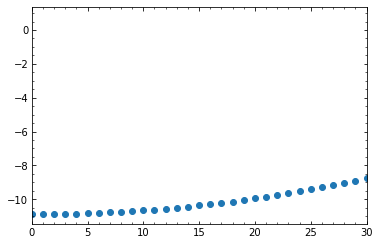

In [16]:
plt.scatter(np.arange(n), ms.U[:])
plt.xlim(0,30)
#plt.ylim(0.915,0.93)

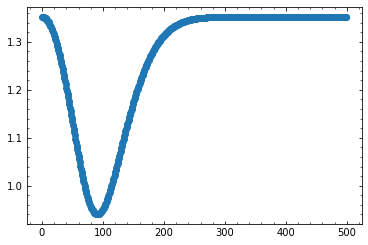

In [1358]:
plt.scatter(np.arange(n), ms.gamma(ms.R, ms.m, ms.U))
#plt.xlim(0,30)
#plt.ylim(0.915,0.93)

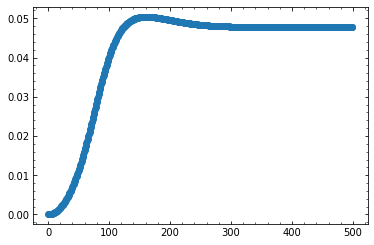

In [1390]:
plt.scatter(np.arange(n), ms.psi(ms.rho(ms.R, ms.m), ms.w * ms.rho(ms.R, ms.m) ) )


(0.0, 30.0)

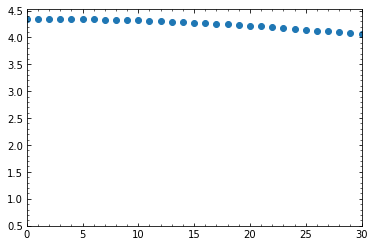

In [1562]:
plt.scatter(np.arange(n), ms.rho(ms.R, ms.m))
plt.xlim(0,30)
#plt.ylim(0.915,0.93)

(0.0, 10.0)

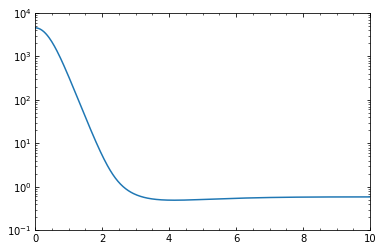

In [20]:
plt.plot(Abar, ms.rho(ms.R, ms.m) )
plt.yscale('log')
plt.ylim(10**-1,10**4)
plt.xlim(0,10)

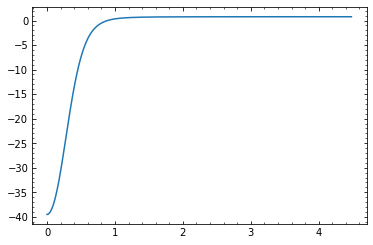

In [21]:
plt.plot(A[:], ms.U[:] )


(0.0, 1.0)

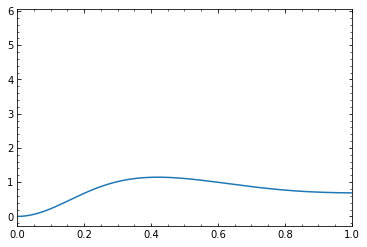

In [22]:
plt.plot(A, ms.R**2 * ms.m * ms.Abar**2 * np.exp(2 * (ms.alpha-1) * ms.xi))

plt.xlim(0,1)

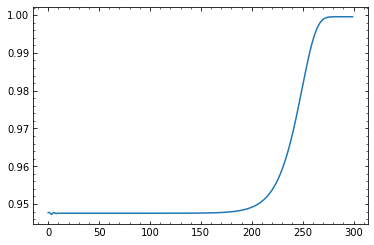

In [632]:
plt.plot( ms.U[:])
#plt.xlim(0,50)
#plt.ylim(0.87,0.92)

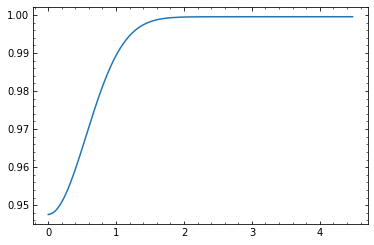

In [631]:
plt.plot(A[20:], ms.U[20:])


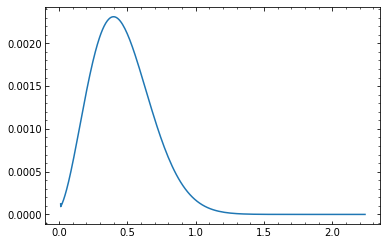

In [319]:
plt.plot(A[5:], (dfdA(ms.U[5:], ms.deltaL, ms.L, ms.RH) ))

In [24]:
test = HM(R, m, U, vs2, deltaL, L)

In [20]:
#@title ICs that work

n=500

L = np.linspace(-2, 0.3, n)
A = 10**L
eps = 0 # some small number for numerical stability

deltaL = L[1] - L[0]
deltaA = A[1] - A[0]
deltau = np.min(deltaA)/5


vs2 = 0.05
# #np.sinh(A) + 1 maybe did something
g = 1 + 0.01*np.exp(A)  # g -> 1 at A=0
c = 0.2*A - 0.01*A**2 # 0.1*np.sqrt(A) - 0.025*A + 0.0005*A*np.exp(-(A-0.2)**2/.2**2) # c -> 0 at A=0 ✓

U = -np.sqrt(g**2 - 1 + 2*c)
m = integ.cumtrapz(np.concatenate(([1], g - vs2*U)), np.concatenate(([0], A))) # m=0 at A=0
R = m/c


In [ ]:
def gamma(R,m,U): 
    return np.sqrt(1+U**2-2*m / R)

def P(R,m,U,vs2) : 
    return vs2*rho(R,m,U)

def rho(R,m,U) : 
    return (gamma(R,m,U) + U) / (4*np.pi*R**2*dfdA(R, deltaL, L))

def psi(R,m,U,g,r,p) : 
  return np.log(g[-1]+U[-1]) + integ.cumtrapz(dfdA(U, deltaL, L)/g + m/(4*np.pi*r*(R**4)*g) + p/(r*g*R), A, initial=0)

def k_coeffs(R,m,U,vs2) :
  g = gamma(R,m,U)
  r = rho(R,m,U)
  p = P(R,m,U,vs2)
  
  ep = np.exp(psi(R,m,U,g,r,p))

  #print(ep)
  kR = ep*U
  km = -1/ep*4*np.pi*R**2*p*U
  kU = -ep/(1-vs2)*( 4*np.pi*g*R**2*r/(r + p)*dfdA(p, deltaL, L) + (m + 4*np.pi*R**3*p)/R**2 ) \
    - ep*vs2/(1-vs2)*(4*np.pi*r*R**2*dfdA(U, deltaL, L) + 2*U*g/R)
  #kU = 1
  return kR, km, kU

def cfl_deltau(R,m,U,vs2) :
    g = gamma(R,m,U)
    r = rho(R,m,U)
    p = P(R,m,U,vs2)
    ep = np.exp(psi(R,m,U,g,r,p))
    Rp = ep * U
    return np.abs(Rp / (U + g) / ep).min() * (1/ np.sqrt(1/3) - 1 )
